In [ ]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.0 MB/s eta 0:00:00


Importar bibliotecas

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch.utils.data import Dataset
import csv
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt



In [ ]:
# Corpus
text_filepath = "/content/emoevent_es.csv"

#text_data = pd.read_csv(text_filepath)
text_data = pd.read_csv(text_filepath, sep='\t', engine = 'python', usecols=[1])
print (text_data)
train_texts, test_texts = train_test_split(text_data.iloc[:, 0].tolist(), test_size=0.2, random_state=0)
labels_data = pd.read_csv(text_filepath, sep='\t', engine = 'python', usecols=[2])
print (labels_data)
label_name = np.unique(labels_data)
print (label_name)
train_labels, test_labels = train_test_split(labels_data.iloc[:, 0].tolist(), test_size=0.2, random_state=0)
le = LabelEncoder()
print (train_labels)
train_labels = le.fit_transform(train_labels)
print (train_labels)
print (test_labels)
test_labels = le.transform(test_labels)
print (test_labels)
#le = LabelEncoder()
#le.fit(["paris", "paris", "tokyo", "amsterdam"])
#labels_data.value_counts(ascending=True).plot.barh()
#plt.title('Frequency of Classes')
#plt.show()
#label_encoder = LabelEncoder()
#train_labels = label_encoder.fit_transform(train_labels)
#test_labels = label_encoder.transform(test_labels)

                                                  tweet
0     Acabo de ver la gran pérdida que estamos tenie...
1     USER ¿A que vamos a reconstruir Notre Dame ant...
2     Desde ayer andan sufriendo por el incendio de ...
3     Muy afectada -como muchísima gente- por lo ocu...
4     Es una mierda lo que paso en HASHTAG pero plea...
...                                                 ...
8404  Dembele es un imbécil, neta es increíble lo pe...
8405  HASHTAG Puta q son desagradables los wnes del ...
8406             Puta que me cae mal Suárez ctm HASHTAG
8407  Como te odio USER, odio tus comentarios filosó...
8408  Miedo me da que mi país esté en manos de perso...

[8409 rows x 1 columns]
      emotion
0     sadness
1     sadness
2       anger
3     sadness
4     disgust
...       ...
8404    anger
8405    anger
8406    anger
8407    anger
8408     fear

[8409 rows x 1 columns]
['anger' 'disgust' 'fear' 'joy' 'others' 'sadness' 'surprise']
['others', 'surprise', 'others', 'sadness', 'ot

In [ ]:
#@title Carga del modelo
# Tokenización y codificación del corpus de entrenamiento y pruebas
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

# Carga del modelo preentrenado y ajuste fino
model = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', num_labels = 7)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
 labels = pred.label_ids
 preds = pred.predictions.argmax(-1)
 f1 = f1_score(labels, preds, average="macro")
 acc = accuracy_score(labels, preds)
 return {"accuracy": acc, "f1": f1}

# Nueva sección

In [ ]:
training_args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=100,
    num_train_epochs=2,
    seed=0,
    load_best_model_at_end=True,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
     compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
100,No log,1.017987,0.645660,0.341063
200,No log,0.963224,0.665874,0.367247
300,No log,1.049220,0.650416,0.410783
400,No log,0.881925,0.690844,0.420156
500,1.021000,0.877872,0.703924,0.457836
600,1.021000,0.902395,0.678954,0.462047
700,1.021000,0.914797,0.677765,0.455156
800,1.021000,0.872528,0.688466,0.458665
900,1.021000,0.878023,0.703924,0.464863
1000,0.854700,0.944561,0.705113,0.475822


TrainOutput(global_step=1892, training_loss=0.7447561542277105, metrics={'train_runtime': 278.5734, 'train_samples_per_second': 54.334, 'train_steps_per_second': 6.792, 'total_flos': 987878359723200.0, 'train_loss': 0.7447561542277105, 'epoch': 2.0})

Predicción

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predecir en el conjunto de prueba
predictions = trainer.predict(test_dataset)

# Las predicciones están en formato logit, así que las convertimos a clases usando argmax
predicted_classes = np.argmax(predictions.predictions, axis=-1)

# Classification report
report = classification_report(test_labels, predicted_classes)
print(report)


# Matriz de confusión
#cm = confusion_matrix(test_labels, predicted_classes)
#class_labels = ["No violento", "Violento"]
#plt.figure(figsize=(8, 6))
#sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
#plt.title("Matriz de Confusión")
#plt.xlabel("Etiqueta Predicha")
#plt.ylabel("Etiqueta Verdadera")
#plt.show()

              precision    recall  f1-score   support

           0       0.62      0.43      0.51        92
           1       0.00      0.00      0.00        14
           2       0.50      0.43      0.46         7
           3       0.71      0.66      0.69       187
           4       0.69      0.87      0.77       410
           5       0.83      0.73      0.78        96
           6       0.00      0.00      0.00        35

    accuracy                           0.70       841
   macro avg       0.48      0.45      0.46       841
weighted avg       0.66      0.70      0.68       841



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
 cm = confusion_matrix(y_true, y_preds, normalize="true")
 fig, ax = plt.subplots(figsize=(6, 6))
 disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
 disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
 plt.title("Normalized confusion matrix")
 plt.show()

[4, 4, 4, 0, 3, 6, 4, 3, 0, 4, 4, 0, 5, 4, 3, 3, 4, 0, 4, 4, 5, 4, 0, 1, 4, 3, 4, 4, 4, 3, 3, 4, 3, 4, 4, 5, 4, 4, 4, 3, 4, 4, 0, 4, 4, 5, 5, 3, 4, 5, 5, 3, 3, 4, 5, 4, 4, 4, 3, 0, 3, 4, 3, 4, 4, 5, 3, 4, 3, 4, 4, 4, 0, 4, 0, 4, 4, 4, 5, 4, 3, 4, 3, 4, 4, 5, 4, 2, 4, 3, 4, 3, 3, 3, 4, 0, 3, 4, 4, 4, 5, 4, 0, 3, 3, 4, 5, 4, 4, 5, 4, 4, 4, 5, 4, 4, 3, 4, 0, 4, 5, 3, 0, 5, 4, 3, 1, 4, 4, 0, 1, 5, 4, 3, 5, 5, 4, 4, 3, 5, 3, 3, 3, 4, 0, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 5, 0, 6, 3, 4, 4, 4, 6, 4, 3, 4, 5, 2, 3, 0, 6, 3, 4, 4, 4, 3, 1, 3, 4, 4, 5, 4, 4, 4, 4, 3, 3, 3, 3, 3, 6, 4, 4, 4, 3, 4, 4, 4, 3, 4, 4, 5, 4, 4, 0, 3, 0, 3, 4, 3, 3, 4, 4, 0, 4, 2, 3, 5, 4, 4, 4, 4, 4, 3, 4, 3, 0, 4, 4, 5, 6, 3, 3, 0, 4, 4, 4, 0, 4, 4, 6, 4, 5, 4, 4, 5, 3, 4, 3, 0, 4, 3, 4, 4, 3, 4, 0, 5, 4, 0, 3, 3, 4, 4, 0, 5, 4, 4, 4, 4, 0, 4, 3, 6, 4, 3, 4, 6, 4, 0, 5, 3, 4, 5, 6, 4, 4, 4, 4, 5, 5, 4, 4, 0, 4, 3, 3, 5, 3, 3, 5, 0, 4, 4, 5, 5, 3, 3, 4, 3, 4, 4, 5, 0, 0, 0, 3, 4, 4, 0, 0, 4, 4, 0, 4, 4, 4, 4, 4, 3, 4, 4, 3, 

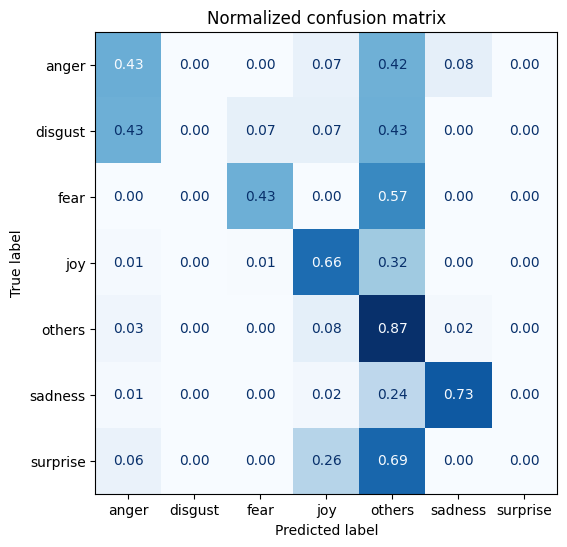

In [ ]:
import numpy as np
y_test = test_labels.tolist()
print (y_test)
plot_confusion_matrix(predicted_classes, y_test, label_name)
